### Gentrification Data Science Project

** TL;DR
This notebook is a primer for my proposed Data Science project on Gentrifications in the United States. It shed light on the following products I am going to build during Data Incubator training.  
1. A centralized data portal that host most comprehensive information around gentrifications, e.g., population demographics, housing, geo-tagged web data (through parsing) including businesses, travel, entertainments etc
2. An interactive analytics tool that enables user to explore gentrification information through visualizations
3. A machine learning model that quantifies future gentrification trend which enables usage of researchers, policy makers and real estate market investors

The fast urbanization sometimes comes with gentrification, a displacement of low-income groups by high-income ones, which has great social and economic impact, including local culture, house values, businesses etc. Knowing whether a district will be gentrified and the factors lead to it will provide useful information for local residents, policy makers, researchers, investors etc. 

Gentrification is related to many demographic and socioeconomic factors including education level of residents, new businesses and even number of check-ins, for which the data is easily obtainable. Demographic information can be obtained via download or API from US census bureau; House values can be obtained from US census bureau too but also readily downloadable from Zillow. Social network location information, e.g., geotags from Flickr.

I will merge the data, feature engineering, build predictive models and keep improving its performance. I will also use Flask to build an interactive analytic application. 

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
import shapefile
from matplotlib.collections import PatchCollection
from sodapy import Socrata
from descartes import PolygonPatch
import requests
import json
import datetime
%matplotlib inline


# 1.  house values
First check hypothesis that the cities that have gentrified most have an higher house price increase than average
by neighborhood, #Data source: Zillow https://www.zillow.com/research/data/#bulk


In [101]:
df_price = pd.read_csv('/Users/fangjie/Downloads/Neighborhood/Neighborhood_Zhvi_AllHomes.csv')

In [102]:
df_price.head(5)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09
0,274772,Northeast Dallas,Dallas,TX,Dallas-Fort Worth,Dallas,1,NaN,NaN,NaN,...,277500,278300,281600,285900,289900,292900,292900,291800,290900,290100
1,192689,Paradise,Las Vegas,NV,Las Vegas,Clark,2,115400.0,115300.0,115500.0,...,196500,199100,201400,202900,204200,206300,208900,211100,213400,215500
2,112345,Maryvale,Phoenix,AZ,Phoenix,Maricopa,3,58900.0,58900.0,58900.0,...,147500,148300,148600,148900,149500,150800,152500,153900,155100,156100
3,27080,Sherman Oaks,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,4,216200.0,218200.0,218900.0,...,869700,872500,876200,879500,882400,886400,891100,896200,903200,910200
4,118208,South Los Angeles,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,5,117600.0,118700.0,119600.0,...,401900,406100,411000,417300,423400,427100,429700,432500,435300,437500


In [103]:
df_price[df_price.City == 'San Francisco'].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09
98,274552,Mission,San Francisco,CA,San Francisco,San Francisco,99,226900.0,226100.0,224400.0,...,1276300,1282100,1283800,1292100,1299500,1299800,1301200,1313700,1336700,1357700
313,268020,Bernal Heights,San Francisco,CA,San Francisco,San Francisco,314,NaN,NaN,NaN,...,1288300,1300000,1307900,1323600,1333200,1331400,1335500,1346800,1351800,1350600
379,117654,Central Richmond,San Francisco,CA,San Francisco,San Francisco,380,327600.0,332100.0,337800.0,...,1454700,1442000,1426600,1421300,1425400,1424900,1419200,1422500,1441900,1462000
389,268150,Excelsior,San Francisco,CA,San Francisco,San Francisco,390,190900.0,191300.0,191800.0,...,832300,835000,839700,851500,866900,882300,896300,905900,914400,921900
448,272885,Bayview,San Francisco,CA,San Francisco,San Francisco,449,NaN,NaN,NaN,...,776600,779200,784300,795200,808700,820000,826800,828300,834000,843400


In [104]:
d[lambda df: df.columns[7:]].transpose().head()

RegionName,Mission,Bernal Heights,Central Richmond,Excelsior,Bayview,Central Sunset,Downtown,Pacific Heights,Nob Hill,Visitacion Valley,...,North Waterfront,Westwood Park,Westwood Highlands,Forest Hill Extension,Little Hollywood,Lakeside,Central Waterfront - Dogpatch,Ingleside Terrace,Mount Davidson Manor,Sea Cliff
1996-04,226900.0,NaN,327600.0,190900.0,NaN,275700.0,203700.0,433400.0,386900.0,168200.0,...,264500.0,267900.0,304700.0,353900.0,177900.0,NaN,NaN,408100.0,310000.0,NaN
1996-05,226100.0,NaN,332100.0,191300.0,NaN,277400.0,203000.0,440200.0,390600.0,167600.0,...,268800.0,272200.0,309500.0,357700.0,180400.0,NaN,NaN,410300.0,315700.0,NaN
1996-06,224400.0,NaN,337800.0,191800.0,NaN,278600.0,201000.0,443600.0,388400.0,168700.0,...,270800.0,275600.0,314800.0,365500.0,183800.0,NaN,NaN,413900.0,319500.0,NaN
1996-07,223300.0,NaN,340500.0,192400.0,NaN,280000.0,198700.0,448700.0,387800.0,169800.0,...,270600.0,278300.0,317500.0,371900.0,186800.0,NaN,NaN,414900.0,322400.0,NaN
1996-08,223900.0,NaN,342000.0,192700.0,NaN,281300.0,197800.0,455200.0,391100.0,170700.0,...,270300.0,281300.0,319700.0,376100.0,189600.0,NaN,NaN,412300.0,323400.0,NaN


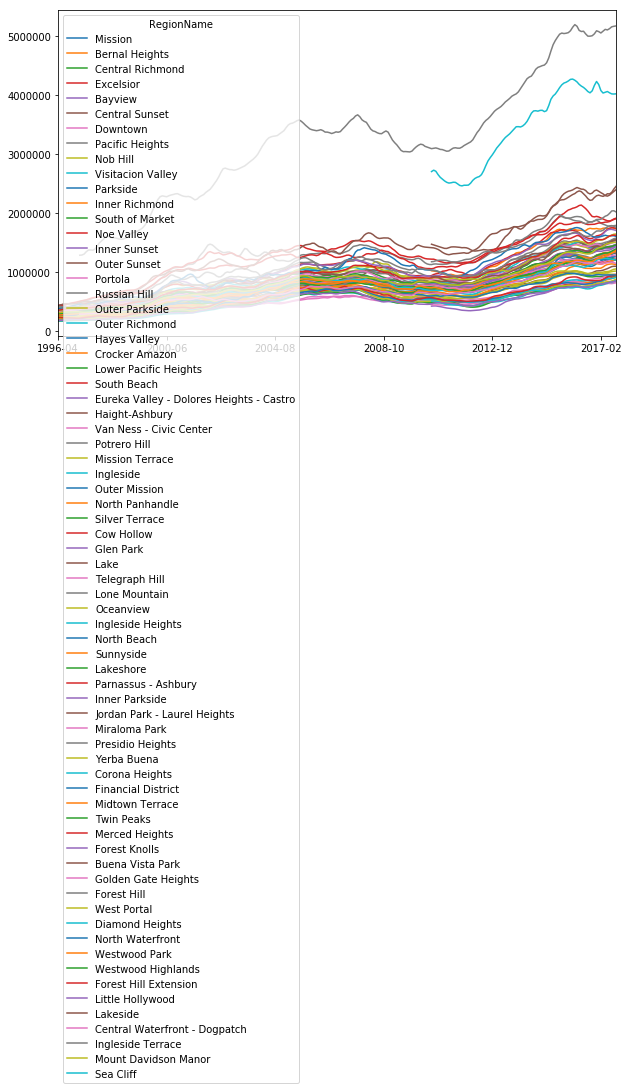

In [105]:
fig, ax = plt.subplots(1,1,figsize = (10,6))
d = df_price[df_price.City == 'San Francisco']
d.set_index(d.RegionName, inplace = True)
t = d[lambda df: df.columns[7:]].transpose()
t.plot(ax = ax)

In [106]:
t.columns

Index([u'Mission', u'Bernal Heights', u'Central Richmond', u'Excelsior',
       u'Bayview', u'Central Sunset', u'Downtown', u'Pacific Heights',
       u'Nob Hill', u'Visitacion Valley', u'Parkside', u'Inner Richmond',
       u'South of Market', u'Noe Valley', u'Inner Sunset', u'Outer Sunset',
       u'Portola', u'Russian Hill', u'Outer Parkside', u'Outer Richmond',
       u'Hayes Valley', u'Crocker Amazon', u'Lower Pacific Heights',
       u'South Beach', u'Eureka Valley - Dolores Heights - Castro',
       u'Haight-Ashbury', u'Van Ness - Civic Center', u'Potrero Hill',
       u'Mission Terrace', u'Ingleside', u'Outer Mission', u'North Panhandle',
       u'Silver Terrace', u'Cow Hollow', u'Glen Park', u'Lake',
       u'Telegraph Hill', u'Lone Mountain', u'Oceanview', u'Ingleside Heights',
       u'North Beach', u'Sunnyside', u'Lakeshore', u'Parnassus - Ashbury',
       u'Inner Parkside', u'Jordan Park - Laurel Heights', u'Miraloma Park',
       u'Presidio Heights', u'Yerba Buena', u'Cor

In [107]:
# the mission district which has been on newsreport for gentrification
list_of_gentrification_areas = ['Mission']

# list_of_gentrification_areas = ['Mission','South of Market', 'Van Ness - Civic Center', 'China Town']
list_of_rich_area = ['']

Text(0,0.5,u'Median Housing Price Increase since 1996')

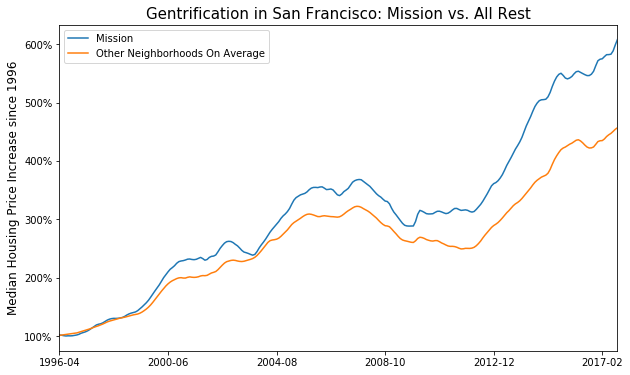

In [108]:
fig, ax = plt.subplots(1,1,figsize = (10,6))
j = 0
t['rescaled_price_accumulate'] = 0
for i, n in enumerate(t.columns):
    t['rescaled_price'] = t[n]/t[n].min()
    
    # directly plot out gentrification areas:
    if n in list_of_gentrification_areas:
        t.rescaled_price.plot(ax = ax, label = n)
    
    # remember non-gentrification areas:
    elif not t.rescaled_price.isnull().values.any():
        t['rescaled_price_accumulate'] += t['rescaled_price']
        j += 1

# at end, plot areas except for gentrification areas on overage..
(t['rescaled_price_accumulate']/j).plot(ax = ax, label = 'Other Neighborhoods On Average')

ax.legend()
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.title("Gentrification in San Francisco: Mission vs. All Rest", fontsize = 15)
ax.set_ylabel("Median Housing Price Increase since 1996", fontsize = 12)

# Visualization for a city, in map

In [109]:
# let's try San Francisco

In [137]:
df_price = df_price[df_price.City == 'San Francisco']
# df_price = df_price[df_price.State == 'CA']
df_price['avg_price_2005'] = df_price[[col for col in list(df_price) if col.startswith('2005')]].mean(axis = 1, skipna=None)
df_price['avg_price_2017'] = df_price[[col for col in list(df_price) if col.startswith('2017')]].mean(axis = 1, skipna=None)
df_price['avg_price_increase_2005_to_2017'] = 100.0*(df_price['avg_price_2017'] / df_price['avg_price_2005'] - 1)
df_price.set_index(df_price.RegionID, inplace = True)

In [143]:
# load shapefile
# download boundary files of states here: https://www.zillow.com/howto/api/neighborhood-boundaries.htm
shapefilename = '/Users/fangjie/Downloads/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA'
# shapefilename = '/Users/fangjie/Downloads/Zoning Districts/geo_export_ff16c4b8-5bf2-4e47-a498-6513bb52d237'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds

coords = (-122.51494757834968,
 37.70808923327349,
 -122.35696687665978,
 37.81157429336938)

shp.close()
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01
coords

(-122.51494757834968,
 37.70808923327349,
 -122.35696687665978,
 37.81157429336938)

In [144]:
# create basemap object
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='SF', drawbounds=False, color='none', zorder=2)


In [145]:
# prepare data
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.SF],
    'name': [hood['Name'] for hood in m.SF_info],
    'city': [hood['City'] for hood in m.SF_info],
    'RegionID': [hood['RegionID'] for hood in m.SF_info],
})

# drop some duplicates
df_map = df_map.drop_duplicates(subset = ['RegionID'])
df_map = df_map[df_map.city == 'San Francisco']
df_map['RegionID'] = df_map.RegionID.astype('int')
df_map.set_index(df_map.RegionID, inplace=True)

In [146]:
# join data together
df_map = df_map.join(df_price, how='inner', on = 'RegionID', lsuffix='_map', rsuffix='_price')

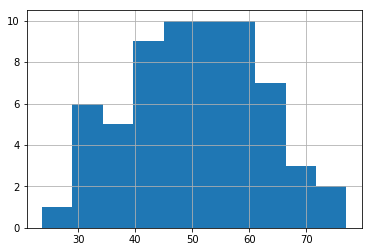

In [147]:
df_map.avg_price_increase_2005_to_2017.hist()

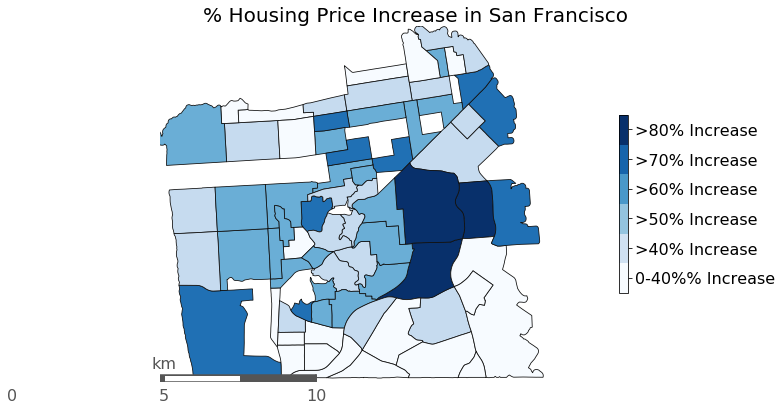

In [150]:
# visualize
# We'll only use a handful of distinct colors for our choropleth. So pick where
# you want your cutoffs to occur. Leave zero and ~infinity alone.

breaks = [40.] + [50, 60, 70., 80.] + [100]

def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return -1
df_map['jenks_bins'] = df_map.avg_price_increase_2005_to_2017.apply(self_categorize, args=(breaks,))

jenks_labels = ['0-40%% Increase']+[">%d%% Increase"%(perc) for perc in breaks[:-1]]

# #Or, you could always use Natural_Breaks to calculate your breaks for you:
# from pysal.esda.mapclassify import Natural_Breaks
# breaks = Natural_Breaks(df_map.avg_price_increase_2005_to_2017, initial=0, k=5)
# df_map['jenks_bins'] = -1 #default value if no data exists for this bin
# df_map['jenks_bins'][df_map.avg_price_increase_2005_to_2017 > 0] = breaks.yb
# jenks_labels = ['', "baseline"]+["> %d increase"%(perc) for perc in breaks.bins[:-1]]

def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar

figwidth = 10
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

cmap = plt.get_cmap('Blues')
# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)

#Draw a map scale

m.drawmapscale(coords[0], coords[1],
    coords[0], coords[1], 10.,
    fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5, ax=ax,)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=16)

fig.suptitle("% Housing Price Increase in San Francisco", fontsize = 5, fontdict={'size':20, 'fontweight':'bold'}, y=0.92)
#ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
# qax.text(1.35, 0.04, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
#     ha='right', color='#555555', style='italic', transform=ax.transAxes)
# ax.text(1.35, 0.01, "BeneathData.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)

plt.savefig('San Francisco housing price changes.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')